In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

In [4]:
train=pd.read_csv('DATA/train.csv')
test=pd.read_csv('DATA/test.csv')

In [5]:
test=test.drop('id',axis=1)
y=train.label.value_counts()

In [6]:
X_train=train.drop('label',axis=1)
Y_train=train.label

In [7]:
X_train=X_train/255
test=test/255 #Scaling to [0,1]

In [8]:
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

print('The shape of train set now is',X_train.shape)
print('The shape of test set now is',test.shape) #Reshaping to 28 x 28

The shape of train set now is (60000, 28, 28, 1)
The shape of test set now is (5000, 28, 28, 1)


In [9]:
Y_train=to_categorical(Y_train) #Encoding

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X_train,Y_train,random_state=42,test_size=0.15)

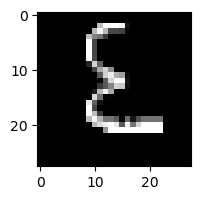

In [11]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[1100][:,:,0], cmap = 'Greys_r')

In [12]:
#Applying transformations and adding data

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [13]:
#Padded convolution

In [14]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation = "softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1

In [16]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

In [17]:
model.compile(optimizer=optimizer,loss=['categorical_crossentropy'],metrics=['accuracy'])

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
#Fitting

epochs=30
batch_size=64

In [20]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (X_test,y_test),
                    verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction])

Epoch 1/30
796/796 - 219s - loss: 0.2620 - accuracy: 0.9158 - val_loss: 0.0395 - val_accuracy: 0.9891 - lr: 0.0010 - 219s/epoch - 275ms/step
Epoch 2/30
796/796 - 255s - loss: 0.0669 - accuracy: 0.9797 - val_loss: 0.0271 - val_accuracy: 0.9927 - lr: 0.0010 - 255s/epoch - 320ms/step
Epoch 3/30
796/796 - 213s - loss: 0.0533 - accuracy: 0.9849 - val_loss: 0.0272 - val_accuracy: 0.9931 - lr: 0.0010 - 213s/epoch - 268ms/step
Epoch 4/30
796/796 - 190s - loss: 0.0446 - accuracy: 0.9865 - val_loss: 0.0253 - val_accuracy: 0.9921 - lr: 0.0010 - 190s/epoch - 239ms/step
Epoch 5/30
796/796 - 191s - loss: 0.0401 - accuracy: 0.9890 - val_loss: 0.0223 - val_accuracy: 0.9929 - lr: 0.0010 - 191s/epoch - 240ms/step
Epoch 6/30
796/796 - 195s - loss: 0.0389 - accuracy: 0.9887 - val_loss: 0.0245 - val_accuracy: 0.9938 - lr: 0.0010 - 195s/epoch - 245ms/step
Epoch 7/30
796/796 - 212s - loss: 0.0357 - accuracy: 0.9898 - val_loss: 0.0233 - val_accuracy: 0.9937 - lr: 0.0010 - 212s/epoch - 266ms/step
Epoch 8/30
79

Text(0, 0.5, 'accuracy')

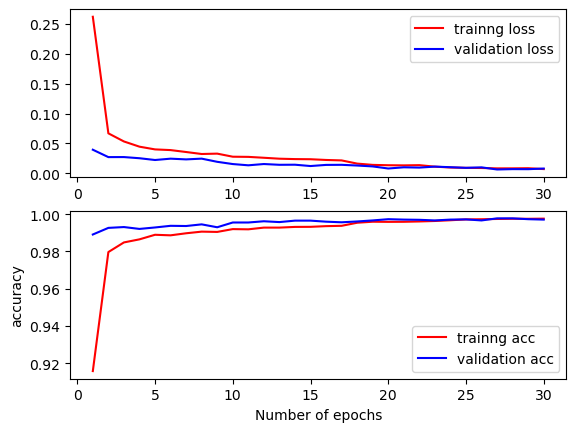

In [21]:
fig,ax=plt.subplots(2,1)
fig.set
x=range(1,1+epochs)
ax[0].plot(x,history.history['loss'],color='red')
ax[0].plot(x,history.history['val_loss'],color='blue')

ax[1].plot(x,history.history['accuracy'],color='red')
ax[1].plot(x,history.history['val_accuracy'],color='blue')
ax[0].legend(['trainng loss','validation loss'])
ax[1].legend(['trainng acc','validation acc'])
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')

In [22]:
y_pre_test=model.predict(X_test)
y_pre_test=np.argmax(y_pre_test,axis=1)
y_test=np.argmax(y_test,axis=1)

282/282 [==============================] - 10s 35ms/step


In [23]:
conf=confusion_matrix(y_test,y_pre_test)
conf=pd.DataFrame(conf,index=range(0,10),columns=range(0,10))

In [24]:
conf

,0,1,2,3,4,5,6,7,8,9
0,850,6,0,1,0,0,0,0,1,0
1,0,913,0,0,0,0,0,0,0,0
2,1,0,907,0,0,0,0,0,0,0
3,0,0,0,883,0,0,0,7,0,0
4,0,0,0,0,925,0,0,0,0,1
5,0,0,0,0,0,874,0,0,0,0
6,0,0,0,0,0,0,858,2,0,2
7,0,0,0,0,0,0,1,932,0,0
8,0,0,0,0,0,0,0,0,918,0
9,0,0,0,0,0,0,3,0,1,914


In [25]:
x=(y_pre_test-y_test!=0).tolist()
x=[i for i,l in enumerate(x) if l!=False]

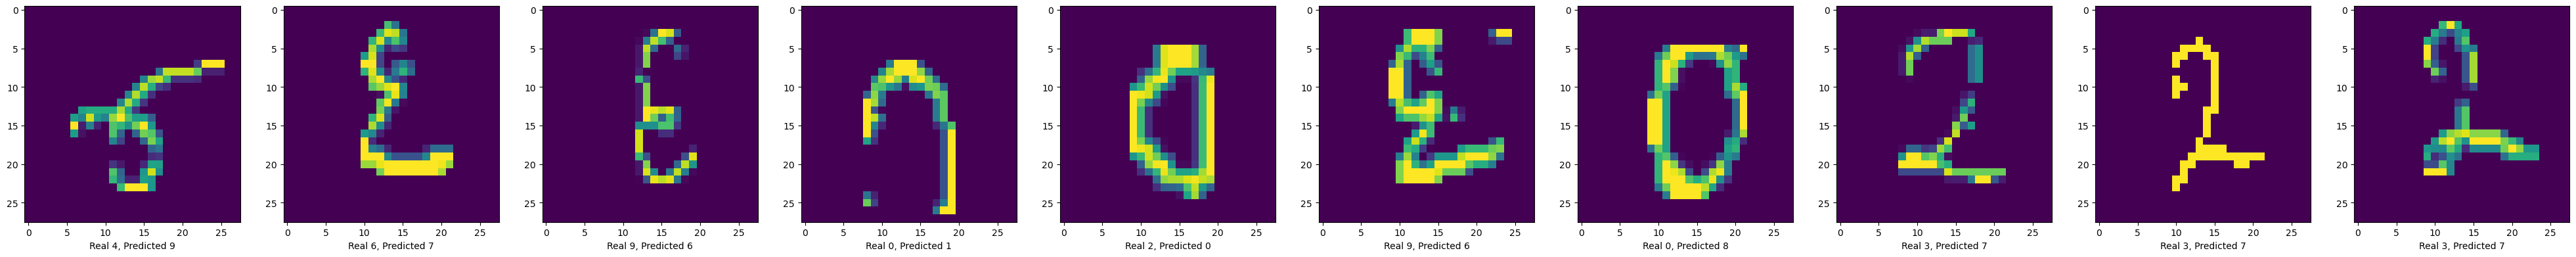

In [26]:
fig,ax=plt.subplots(1,10,sharey=False,figsize=(50,50))

for i in range(10):
    ax[i].imshow(X_test[x[i]][:,:,0])
    ax[i].set_xlabel('Real {}, Predicted {}'.format(y_test[x[i]],y_pre_test[x[i]]))

In [27]:
model.save(filepath = "Your filepath and filename") #saved it as 'test.h5'

Data - https://www.kaggle.com/competitions/Kannada-MNIST/data
<br />Notebook used as reference - https://www.kaggle.com/code/shahules/indian-way-to-learn-cnn